## Import dependencies

In [2]:
from datetime import datetime
import numpy as np
import pandas_datareader as pdr
from datetime import datetime
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from functools import partial
from scipy.integrate import quad

from matplotlib import pyplot as plt
import utils
import alPhaStablePricer as alpha
import ghPricer as gh
import mertonPricer as merton

## Read data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-06-27,23.262501,22.875000,23.250000,23.010000,181958400.0,21.495594
2016-06-28,23.415001,23.035000,23.225000,23.397499,161779600.0,21.857594
2016-06-29,23.637501,23.407499,23.492500,23.600000,146124000.0,22.046766
2016-06-30,23.942499,23.575001,23.610001,23.900000,143345600.0,22.327021
2016-07-01,24.117500,23.832500,23.872499,23.972500,104106000.0,22.394749
...,...,...,...,...,...,...
2021-06-14,130.539993,127.070000,127.820000,130.479996,96906500.0,130.479996
2021-06-15,130.600006,129.389999,129.940002,129.639999,62746300.0,129.639999
2021-06-16,130.889999,128.460007,130.369995,130.149994,91815000.0,130.149994


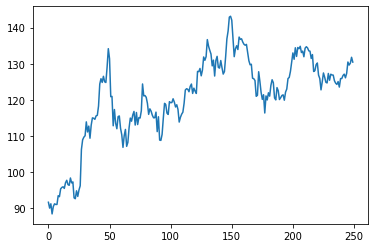

In [3]:
df = pdr.data.DataReader("AAPL",'yahoo', #"av-intraday",
                         end=datetime(2021, 6, 20, 15, 28, 47, 573840),#datetime.today()
                         api_key="ZDT39A5EINVODTVI")
display(df)
df["Close"][-250:].plot(use_index=False)
initial_value=df["Close"][-1]
df.index = pd.to_datetime(df.index)

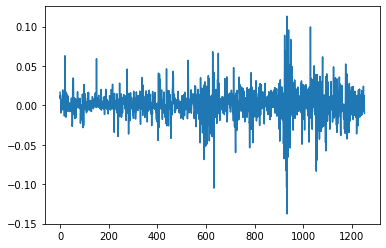

Date
2016-06-28    0.016700
2016-06-29    0.008618
2016-06-30    0.012632
2016-07-01    0.003029
2016-07-05   -0.009430
Name: Close, dtype: float64

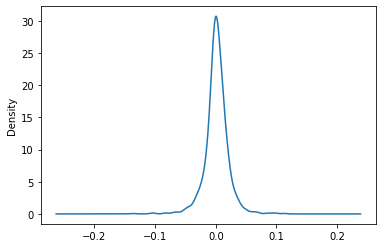

In [4]:
df = pd.Series(np.log(df.Close) - np.log(df.Close.shift(1))[1:],index=df.index[1:])
df.plot(use_index=False)
plt.show()
df.plot.kde()
df.head()

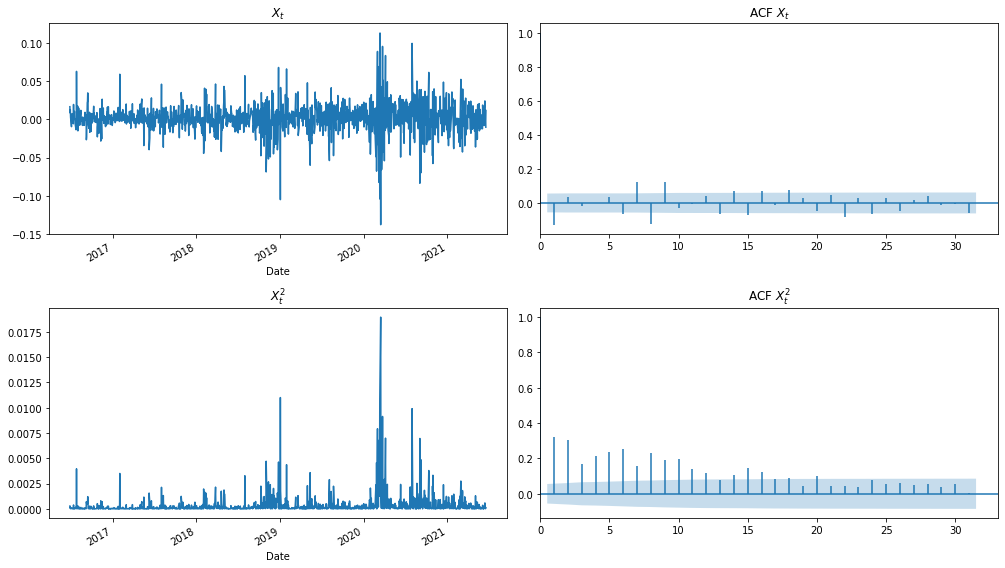

In [5]:
def tsplot(y, figsize=(14, 8),xlim=(-0.1,0.1)):

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    ac_ax = plt.subplot2grid(layout, (0, 1))
    ts_ax2  = plt.subplot2grid(layout, (1, 0))
    ac_ax2 = plt.subplot2grid(layout, (1, 1))
    
    y2=pd.Series([x**2 for x in y],index=y.index)

    y.plot(ax=ts_ax,title=r'$X_t$',x_compat=True)
    y2.plot(ax=ts_ax2,title=r'$X_t^2$',x_compat=True)
    
    smt.graphics.plot_acf(y, lags=None, ax=ac_ax,marker=None,title=r'ACF $X_t$')
    smt.graphics.plot_acf(y2, lags=None, ax=ac_ax2,marker=None,title=r'ACF $X_t^2$')
    
    [ax.set_xlim(0) for ax in [ac_ax, ac_ax2]]

    
    fig.tight_layout()
    plt.savefig('logReturns.eps', format='eps')
    plt.show()
tsplot(df)

## Data subset

In [6]:
dataset = df[-250:]

In [7]:
dataset

Date
2020-06-23    0.021120
2020-06-24   -0.017810
2020-06-25    0.013188
2020-06-26   -0.031208
2020-06-29    0.022785
                ...   
2021-06-14    0.024281
2021-06-15   -0.006459
2021-06-16    0.003926
2021-06-17    0.012522
2021-06-18   -0.010143
Name: Close, Length: 250, dtype: float64

In [8]:
print("Shapiro test of normality: statistic={}, p_value={}".format(st.shapiro(dataset)[0],st.shapiro(dataset)[1]))

Shapiro test of normality: statistic=0.977552592754364, p_value=0.00054467300651595


In [9]:
print("Jarque Bera test of normality: statistic={}, p_value={}".format(st.jarque_bera(dataset)[0],st.shapiro(dataset)[1]))

Jarque Bera test of normality: statistic=48.39947581560408, p_value=0.00054467300651595


We can reject the null hypothesis H0 that the returns are normally distributed

## Fit models

In [10]:
alpha_model = alpha.AlPhaStablePricer()

In [11]:
%%time
alpha_model.fit(dataset)

CPU times: user 12min 25s, sys: 25.8 ms, total: 12min 25s
Wall time: 12min 25s


In [12]:
merton_model = merton.MertonPricer()

In [13]:
%%time
merton_model.fit(dataset,T=1)

CPU times: user 1min 37s, sys: 417 ms, total: 1min 37s
Wall time: 1min 37s


In [14]:
gh_model = gh.GhPricer()

In [15]:
%%time
gh_model.fit(dataset,1000)

CPU times: user 2min 49s, sys: 176 ms, total: 2min 50s
Wall time: 2min 50s


## Probability density and cumulative distribution function

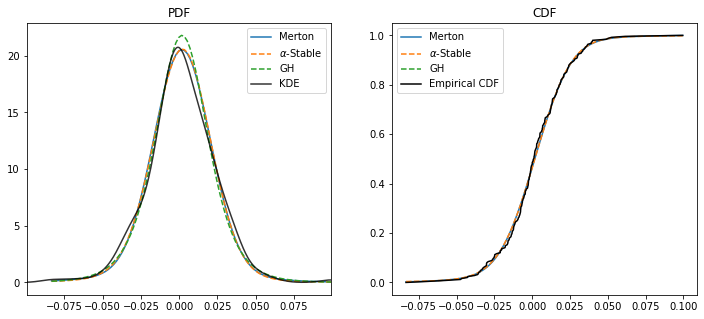

In [16]:
#####################################################
########  Probability density function   ########
#####################################################

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))
N=100
x_grid = np.linspace(dataset.min(),dataset.max(),N)

ax[0].plot(x_grid,
        [merton_model.Merton_density(j,
                                     T=1,
                                     lam= merton_model.lam,
                                     mu=merton_model.mu,
                                     muJ=merton_model.muJ,
                                     sig=merton_model.sig,
                                     sigJ=merton_model.sigJ) for j in x_grid],
        label="Merton",linestyle='-')


ax[0].plot(x_grid,
         [st.levy_stable.pdf(x, 
                          alpha=alpha_model.alpha,
                          beta=alpha_model.betta,
                          loc=alpha_model.mu,
                          scale=alpha_model.c) for x in x_grid],
        label=r'$\alpha$-Stable',linestyle='--')


ax[0].plot(x_grid,
        [gh_model.GH_density(j,
                             alpha= gh_model.alpha,
                             betta=gh_model.betta,
                             delta=gh_model.delta,
                             lam=gh_model.lam,
                             mu=gh_model.mu) for j in x_grid],
        label="GH",linestyle='--')

dataset.plot.kde(label="KDE", ax=ax[0], color="black",alpha=0.8)
ax[0].axis(xmin=-dataset.max(),xmax=dataset.max())
ax[0].legend()
ax[0].set_title("PDF")
ax[0].set_ylabel("")

#####################################################
########  Cumulative distribution function   ########
#####################################################

p_Merton = partial(merton_model.Merton_density,
                  T=1,
                  lam= merton_model.lam,
                  mu=merton_model.mu,
                  muJ=merton_model.muJ,
                  sig=merton_model.sig,
                  sigJ=merton_model.sigJ)

p_GH = partial(gh_model.GH_density,
               delta=gh_model.delta,
               mu=gh_model.mu,
               lam=gh_model.lam,
               alpha=gh_model.alpha,
               betta=gh_model.betta)


ax[1].plot(x_grid,
        [quad(p_Merton,-np.inf,x)[0] for x in x_grid],
        label="Merton",linestyle='-')

ax[1].plot(x_grid,  
        [st.levy_stable(alpha=alpha_model.alpha,
                        beta=alpha_model.betta,
                        loc=alpha_model.mu,
                        scale=alpha_model.c).cdf(x) for x in x_grid],
        label=r'$\alpha$-Stable',linestyle='--')

ax[1].plot(x_grid,
        [quad(p_GH,-np.inf,x)[0] for x in x_grid],
        label="GH",linestyle='--')
 
ax[1].plot(np.sort(dataset), 1. * np.arange(len(dataset)) / (len(dataset) - 1),label="Empirical CDF", color="black")
plt.legend()
ax[1].set_title("CDF")
plt.savefig('PdfAndCdf.eps', format='eps')
plt.show()

### AIC

In [17]:
pd.DataFrame({"Merton":merton_model.aic,
              "GH":gh_model.aic,
              "Alpha-Stable":alpha_model.aic}.items(),
             columns=["Model","AIC"]).sort_values("AIC")

,Model,AIC
2,Alpha-Stable,-1209.693433
0,Merton,-1209.071903
1,GH,-1208.943568


## Pricing

In [18]:
r=1.5/100 #risk free rate
S0=initial_value
K=S0
T=15  #1
print(S0)

130.4600067138672
1


###  Martingale corrections

In [19]:
cf_mert_mcm = partial(merton_model.cf_mert,
                       t=T,
                       mu= merton_model.mu+r-merton_model.mcm,
                       sig= merton_model.sig,
                       lam= merton_model.lam,
                       muJ= merton_model.muJ,
                       sigJ= merton_model.sigJ)


cf_stable_mcm = partial(alpha_model.cf_stable,
                       alpha=alpha_model.alpha,
                       betta=alpha_model.betta,
                       mu=alpha_model.mu+r-alpha_model.mcm,
                       c=alpha_model.c)


cf_GH_mcm = partial(gh_model.cf_GH,
                    t=T,
                    delta = gh_model.delta,               
                    mu= gh_model.mu+r-gh_model.mcm,
                    lam= gh_model.lam,
                    alpha=gh_model.alpha,
                    betta=gh_model.betta)
                    
print(alpha_model.mcm)
print(merton_model.mcm)
print(gh_model.mcm)

(0.0009323263123193399-1.9444249446021112e-05j)
(0.0017347192226738308+0j)
(5.677632682451414+0j)


### Results

In [20]:
%%time
data = [{'model': "Stable",
         "Call_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_stable_mcm,payoff="call",T=T),
         "Call_MC":alpha_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=1000),
         "Put_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_stable_mcm,payoff="put",T=T),
         "Put_MC":alpha_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="put",N=100000)},
       {'model': "Merton",
         "Call_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_mert_mcm,payoff="call",T=T),
         "Call_MC":merton_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=100000),
         "Put_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_mert_mcm,payoff="put",T=T),
         "Put_MC":merton_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="put",N=100000)},
       {'model': "GH",
         "Call_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_GH_mcm,payoff="call",T=T),
         "Put_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_GH_mcm,payoff="put",T=T)
       }]
        
pd.DataFrame.from_dict(data)

CPU times: user 12.6 s, sys: 1.14 s, total: 13.8 s
Wall time: 12.2 s


,model,Call_Fourier,Call_MC,Put_Fourier,Put_MC
0,Stable,3.069061,"(2.3038122750579375, 0.06645414920925213)",1.126765,"(0.28834409757916757, 0.002444358155731417)"
1,Merton,3.028890,"(2.13987199961611, 0.006912381889854308)",1.086593,"(0.4400095951649537, 0.0037122753109199887)"
2,GH,-0.982128,NaN,-2.924424,NaN


## Plots

In [21]:
Ks = [i for i in range(1,200)]
plots= [{'model': "Stable",
         "Call_Fourier":[utils.fourierPricer(K=k,S0=S0,r=r,cf=cf_stable_mcm,payoff="call",T=T) for k in Ks],
        "Call_MC":[alpha_model.mcPricer(K=k,r=r,T=T,S0=S0,payoff="call",N=10000)[0] for k in Ks],
         "Put_Fourier":[utils.fourierPricer(K=k,S0=S0,r=r,cf=cf_stable_mcm,payoff="put",T=T) for k in Ks],
         "Put_MC":[alpha_model.mcPricer(K=k,r=r,T=T,S0=S0,payoff="put",N=10000)[0]for k in Ks]},
       {'model': "Merton",
         "Call_Fourier":[utils.fourierPricer(K=k,S0=S0,r=r,cf=cf_mert_mcm,payoff="call",T=T) for k in Ks],
         "Call_MC":[merton_model.mcPricer(K=k,r=r,T=T,S0=S0,payoff="call",N=10000)[0]for k in Ks],
         "Put_Fourier":[utils.fourierPricer(K=k,S0=S0,r=r,cf=cf_mert_mcm,payoff="put",T=T) for k in Ks],
         "Put_MC":[merton_model.mcPricer(K=k,r=r,T=T,S0=S0,payoff="put",N=10000)[0]for k in Ks]},
       {'model': "GH",
         "Call_Fourier":[utils.fourierPricer(K=k,S0=S0,r=r,cf=cf_GH_mcm,payoff="call",T=T)for k in Ks],
         "Put_Fourier":[utils.fourierPricer(K=k,S0=S0,r=r,cf=cf_GH_mcm,payoff="put",T=T)for k in Ks]
       }]

## Calibration with market values

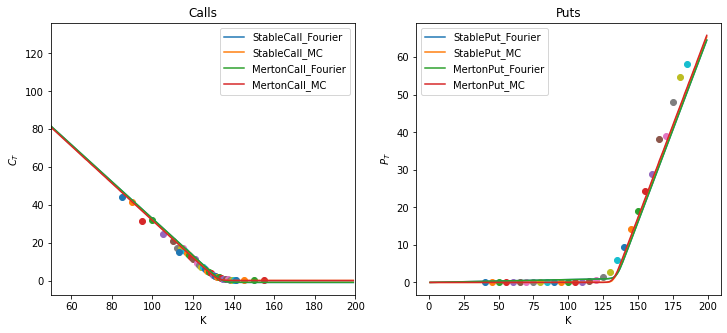

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))

#####################################################
########  CALLS   ########
#####################################################



for i in plots:
    for j in i.keys():
        if ((j!="model") and (j!="Put_Fourier") and (j!="Put_MC")):
            if i["model"]!="GH":
                ax[0].plot(Ks,i[j],label=i["model"]+j)
ax[0].set_title("Calls")
ax[0].set_xlabel("K")
ax[0].set_ylabel(r'$C_T$')
ax[0].legend()
for i in calls:
    ax[0].scatter(i[0],i[1])
ax[0].set_xlim([50,200])


#####################################################
########  PUTS   ########
#####################################################


for i in plots:
    for j in i.keys():
        if ((j!="model") and (j!="Call_Fourier") and (j!="Call_MC")):
            if i["model"]!="GH":
                ax[1].plot(Ks,i[j],label=i["model"]+j)
ax[1].set_xlabel("K")
ax[1].set_ylabel(r'$P_T$')
plt.legend()
ax[1].set_title("Puts")
for i in puts:
    ax[1].scatter(i[0],i[1])
plt.savefig('CallAndPut.eps', format='eps')
plt.show()

In [23]:
print("time of pricess taken from yahoo :", "2021-06-20 20:31:50.354442")

calls =[[85.00 , 43.90] ,
[90.00 , 41.25] ,
[100.00 , 32.10] ,
[95.00 , 31.33] ,
[105.00 , 24.60] ,
[110.00 , 20.83] ,
[115.00 , 17.26] ,
[112.00 , 17.20] ,
[114.00 , 16.95] ,
[116.00 , 15.51] ,
[113.00 , 15.10] ,
[117.00 , 14.69] ,
[118.00 , 13.40] ,
[119.00 , 12.50] ,
[121.00 , 11.35] ,
[120.00 , 11.20] ,
[122.00 , 9.50] ,
[123.00 , 8.25] ,
[124.00 , 7.35] ,
[125.00 , 6.90] ,
[126.00 , 5.95] ,
[127.00 , 5.20] ,
[128.00 , 4.45] ,
[129.00 , 3.75] ,
[130.00 , 3.17] ,
[131.00 , 2.56] ,
[132.00 , 2.08] ,
[133.00 , 1.66] ,
[134.00 , 1.31] ,
[135.00,  1.03],
[131.00 , 2.56] ,
[132.00 , 2.08] ,
[133.00 , 1.66] ,
[134.00 , 1.31] ,
[135.00 , 1.03] ,
[136.00 , 0.80] ,
[137.00 , 0.66] ,
[138.00 , 0.50] ,
[139.00 , 0.41] ,
[140.00 , 0.31] ,
[141.00 , 0.24] ,
[145.00 , 0.12] ,
[150.00 , 0.06] ,
[155.00 , 0.04]]


puts = [[40.00 , 0.02] ,
[45.00 , 0.01 ],
[50.00 , 0.01 ],
[55.00 , 0.01 ],
[60.00 , 0.01 ],
[65.00 , 0.01 ],
[70.00 , 0.02 ],
[75.00 , 0.02 ],
[80.00 , 0.03 ],
[85.00 , 0.04 ],
[90.00 , 0.05 ],
[95.00 , 0.08 ],
[100.00 , 0.10 ],
[105.00 , 0.18 ],
[110.00 , 0.25 ],
[115.00 , 0.37 ],
[120.00 , 0.63 ],
[125.00 , 1.33 ],
[130.00 , 2.89 ],
[135.00 , 5.87 ],
[140.00 , 9.52 ],
[145.00 , 14.25] ,
[150.00 , 19.15] ,
[155.00 , 24.33] ,
[160.00 , 29.00] ,
[165.00 , 38.21] ,
[170.00 , 39.15] ,
[175.00 , 48.20] ,
[180.00 , 54.62] ,
[185.00 , 58.10]]

time of pricess taken from yahoo : 2021-06-20 20:31:50.354442


Above prices are taken from https://finance.yahoo.com/quote/AAPL/options?date=1626393600

## Measuring performance

### Different models

In [24]:
%%time
utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_stable_mcm,payoff="call",T=T)

CPU times: user 4.38 ms, sys: 1 µs, total: 4.38 ms
Wall time: 4.39 ms


3.069060968472968

In [25]:
%%time
alpha_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=10000)

CPU times: user 10.6 ms, sys: 4 µs, total: 10.6 ms
Wall time: 10 ms


(2.359228670613478, 0.020767481122518448)

In [26]:
%%time
utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_mert_mcm,payoff="call",T=T)

CPU times: user 3.24 ms, sys: 3 µs, total: 3.24 ms
Wall time: 3.25 ms


3.0288897764452116

In [27]:
%%time
merton_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=10000)

CPU times: user 752 ms, sys: 112 ms, total: 864 ms
Wall time: 659 ms


(2.16911683785805, 0.02190390844289052)

In [28]:
%%time
utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_GH_mcm,payoff="call",T=T)

CPU times: user 167 ms, sys: 4 ms, total: 171 ms
Wall time: 170 ms


-0.9821276201990088

### Monte carlo, different number of samples vs expected error

#### $\alpha$-stable

In [29]:
%%time
alpha_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=10**2)

CPU times: user 3.93 ms, sys: 0 ns, total: 3.93 ms
Wall time: 2.48 ms


(2.5845580286651084, 0.24220689883760427)

In [30]:
%%time
alpha_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=10**4)

CPU times: user 9.95 ms, sys: 0 ns, total: 9.95 ms
Wall time: 9.53 ms


(2.337985304298219, 0.02087585739965252)

In [31]:
%%time
alpha_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=10**8)

CPU times: user 1min 18s, sys: 25.9 s, total: 1min 44s
Wall time: 1min 44s


(2.3746917192433585, 0.00021545556682880007)

### Merton

In [32]:
%%time
merton_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=10**2)

CPU times: user 9.77 ms, sys: 38 µs, total: 9.81 ms
Wall time: 7.59 ms


(1.9799579784630044, 0.23471752066347848)

In [33]:
%%time
merton_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=10**4)

CPU times: user 783 ms, sys: 82 ms, total: 865 ms
Wall time: 657 ms


(2.124938223004035, 0.021602211482284223)

In [34]:
%%time
merton_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=10**8)

CPU times: user 1h 43min 11s, sys: 9min 15s, total: 1h 52min 26s
Wall time: 1h 38min 29s


(2.137799801470932, 0.0002183852493136003)